Link to Dataset: https://www.kaggle.com/datasets/philosopher0808/real-vs-ai-generated-faces-dataset

Lie, Samuel Miracle Kristanto - 0706012210011
Nathan Darrell - 0706012210034

In [1]:
import tensorflow as tf

print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print("\n\nNumber of GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))

2025-06-06 20:30:20.138141: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-06 20:30:20.200835: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-06 20:30:21.207762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18137196626046287405
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 358481920
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15330457726112670404
physical_device_desc: "device: 0, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


Number of GPUs Available:  1


2025-06-06 20:30:23.414078: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 341 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5


## Read Dataset & Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os

data_dir = "data_source"
print(os.listdir(data_dir))

['fake2', 'real3', 'real1', 'real4', 'fake3', 'fake1', 'fake4', 'real2']


In [4]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Rescaling

# Directory of split folders
split_base = 'data_source'
image_size = (224, 224)
batch_size = 256

def get_image_paths_and_labels(base_dir):
    image_paths = []
    labels = []

    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        label = 0 if folder.startswith('real') else 1  # real = 0, fake = 1
        for f in os.listdir(folder_path):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(folder_path, f))
                labels.append(label)

    return image_paths, labels

image_paths, labels = get_image_paths_and_labels(split_base)

# Split manually into train/val
from sklearn.model_selection import train_test_split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=123, stratify=labels
)

def process_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.cast(img, tf.float32) / 255.0  # normalize
    return img, label

# Build train dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build val dataset
validation_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
validation_ds = validation_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


2025-06-06 20:30:24.502143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 341 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5


In [5]:
print(f"Total images found: {len(image_paths)}")
print(f"Using {len(train_paths)} images for training.")
print(f"Using {len(val_paths)} images for validation.")

num_real = sum(1 for label in labels if label == 0)
num_fake = sum(1 for label in labels if label == 1)

print(f"Class distribution:")
print(f"Real images: {num_real}")
print(f"Fake images: {num_fake}")


Total images found: 80000
Using 56000 images for training.
Using 24000 images for validation.
Class distribution:
Real images: 40000
Fake images: 40000


## Model Building --> MobileNetV3 Large

In [6]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.25),
    # RandomZoom(0.1),
    # RandomContrast(0.1),
    # layers.RandomBrightness(0.1),
])

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC

def MobileNetV3_Large(input_shape=(224, 224, 3), num_classes=1):
    base_model = MobileNetV3Large(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = False # Kalo True ---> Unfreezing / Fine-tuning the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss=BinaryCrossentropy(label_smoothing=0.05),
        metrics=[
            'accuracy',
            Precision(name="precision"),
            Recall(name="recall"),
            AUC(name="auc")
        ]
    )

    return model

In [8]:
model = MobileNetV3_Large(input_shape=(224, 224, 3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 1)                 961       
                                                                 
Total params: 2997313 (11.43 MB)
Trainable params: 961 (3.75 

In [9]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)

In [11]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(weights))
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_labels),
#     y=train_labels
# )
# class_weights_dict = dict(enumerate(class_weights))

In [12]:
from datetime import datetime

start_time = datetime.now()

history = model.fit(
    train_ds,
    batch_size = batch_size,
    epochs = 20,
    validation_data = validation_ds,
    verbose = 1,
    # class_weight=class_weights,
    callbacks=[lr_callback, early_stop],
)

end_time = datetime.now()

model.save('reyalfakeh2.keras')

Epoch 1/20


2025-06-06 20:30:41.889708: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 196.00MiB (rounded to 205520896)requested by op model/MobilenetV3large/Conv/Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-06-06 20:30:41.889784: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2025-06-06 20:30:41.889810: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 151, Chunks in use: 151. 37.8KiB allocated for chunks. 37.8KiB in use in bin. 6.7KiB client-requested in use in bin.
2025-06-06 20:30:41.889830: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 89, Chunks in use: 89. 52.8KiB allocated for chunks. 52.8KiB in use in bin. 41.6KiB client-requested in use in bin.
2025-06-06 20:30:41.8898

ResourceExhaustedError: Graph execution error:

Detected at node 'model/MobilenetV3large/Conv/Conv2D' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3047, in run_cell
      result = self._run_cell(
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3102, in _run_cell
      result = runner(coro)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3489, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3549, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_239945/1422383788.py", line 5, in <module>
      history = model.fit(
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/sift-pc/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'model/MobilenetV3large/Conv/Conv2D'
OOM when allocating tensor with shape[256,16,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/MobilenetV3large/Conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_11118]

## Model Evaluation & Testing

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, AUC

model = load_model(
    'reyalfakeh2.keras',
    custom_objects={
        'Precision': Precision,
        'Recall': Recall,
        'AUC': AUC
    }
)

In [ ]:
import numpy as np

print("Training Duration: " + str(end_time - start_time))
print("Training")
print("Loss: {:.4f}".format(np.average(history.history['loss'])))
print("Accuracy: {:.4f}".format(np.average(history.history['accuracy'])))
print("Recall: {:.4f}".format(np.average(history.history['recall'])))
print("Precision: {:.4f}".format(np.average(history.history['precision'])))

print("Validation")
print("Loss: {:.4f}".format(np.average(history.history['val_loss'])))
print("Accuracy: {:.4f}".format(np.average(history.history['val_accuracy'])))
print("Recall: {:.4f}".format(np.average(history.history['val_recall'])))
print("Precision: {:.4f}".format(np.average(history.history['val_precision'])))

Training Duration: 0:24:08.200307
Training
Loss: 0.6533
Accuracy: 0.6232
Recall: 0.6670
Precision: 0.6130
Validation
Loss: 0.6483
Accuracy: 0.6274
Recall: 0.7753
Precision: 0.5993


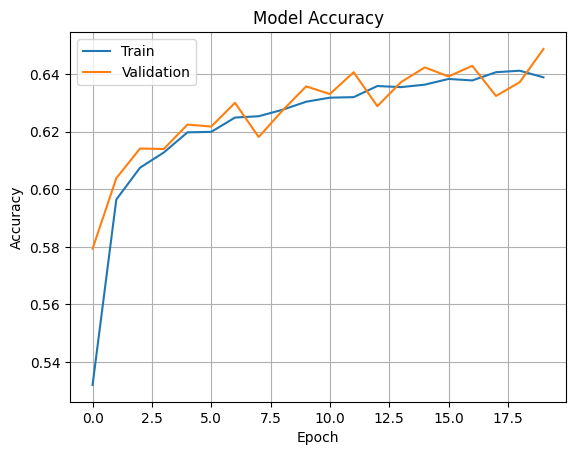

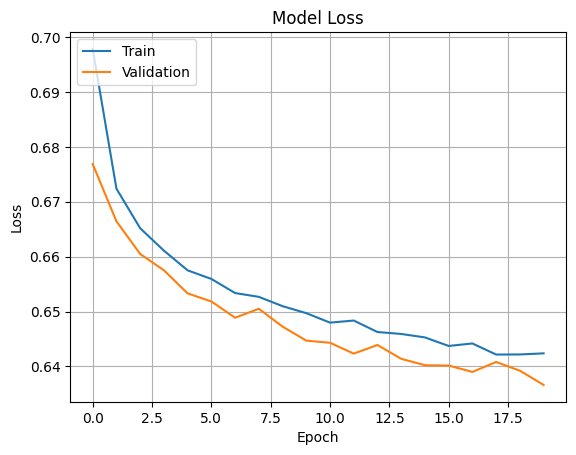

In [ ]:
import matplotlib.pyplot as plt

def plotAccuracy(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid()
    plt.show()

def plotLoss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid()
    plt.show()

plotAccuracy(history)
plotLoss(history)

/home/sift-pc/anaconda3/envs/tf-gpu/bin/python
              precision    recall  f1-score   support

        Real       0.68      0.57      0.62     12000
        Fake       0.63      0.73      0.68     12000

    accuracy                           0.65     24000
   macro avg       0.65      0.65      0.65     24000
weighted avg       0.65      0.65      0.65     24000



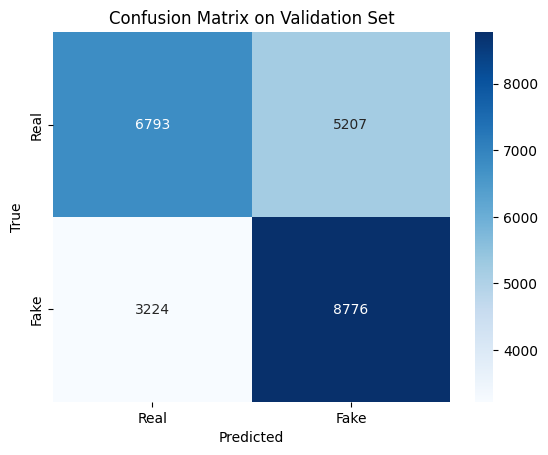

In [ ]:
import sys
print(sys.executable)
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []
y_prob = []

for images, labels in validation_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())
    y_prob.extend(preds.flatten())

# Classification report
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Validation Set")
plt.show()

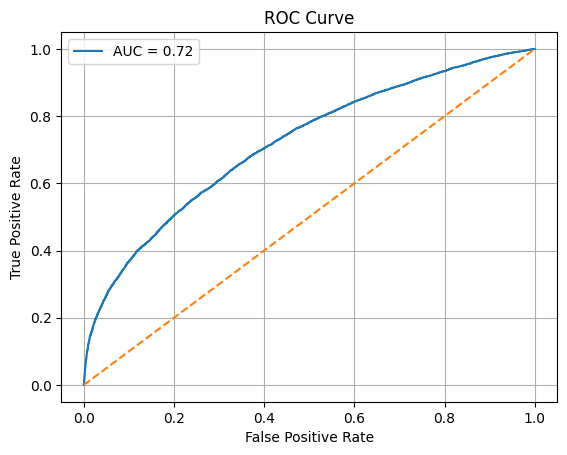

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

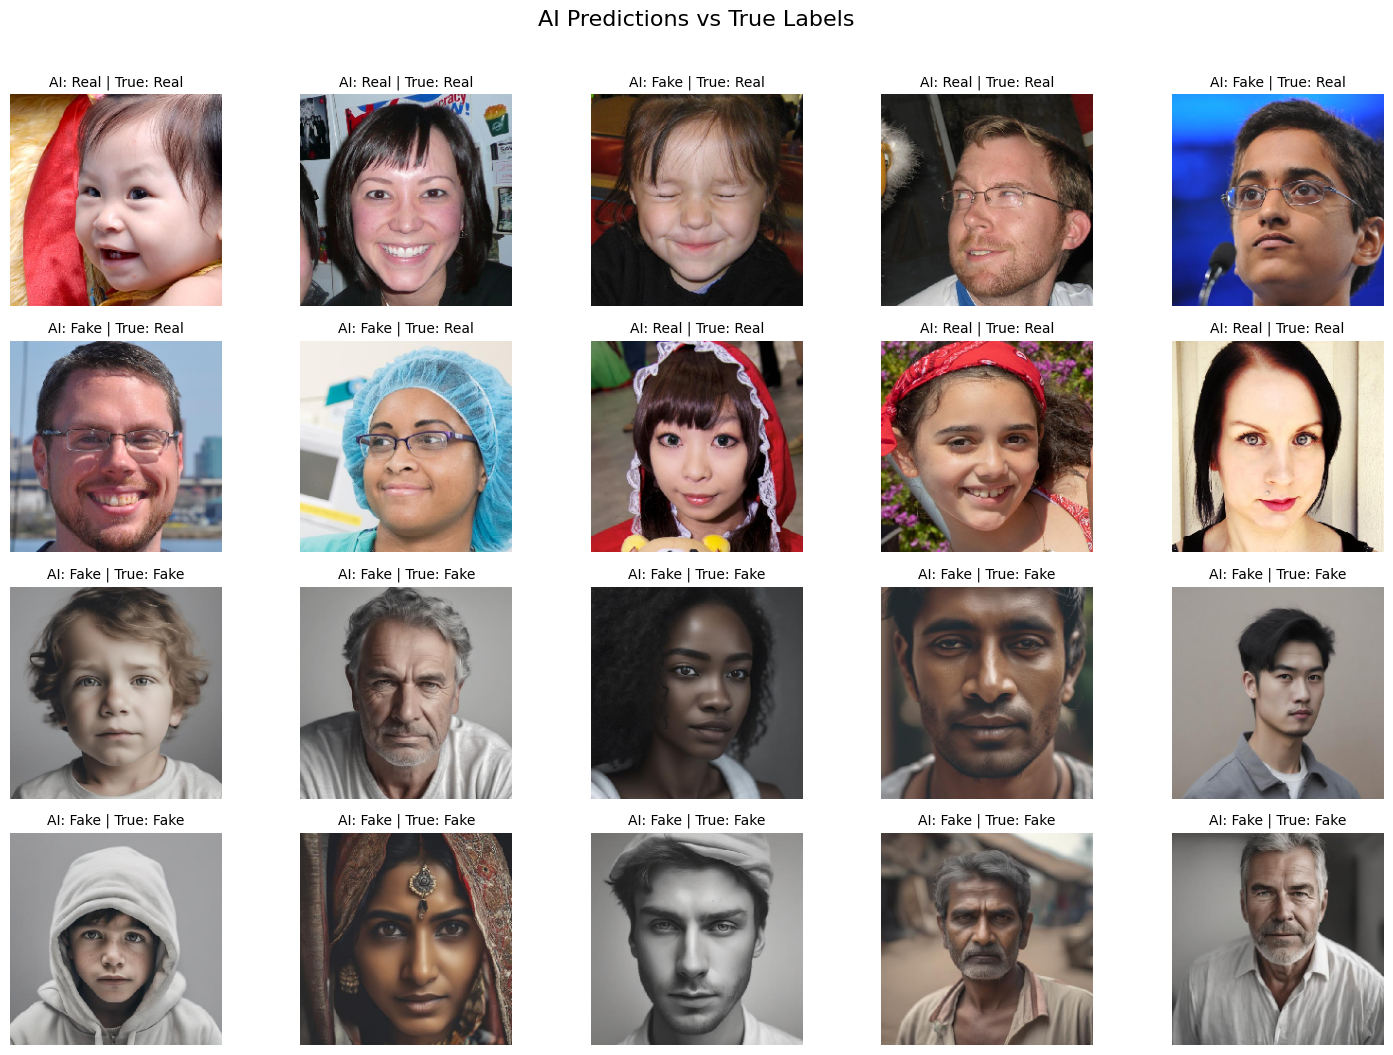

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

test_base = 'outside50k_data'
IMG_SIZE = (224, 224)

label_map = {
    'real8': 0,
    'fake6': 1
}

true_labels = []
predicted_labels = []

# Setup plot
plt.figure(figsize=(15, 10))
i = 1  # subplot index

for folder, label in label_map.items():
    folder_path = os.path.join(test_base, folder)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_file in image_files[:10]:  # limit per folder
        img_path = os.path.join(folder_path, img_file)
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img)
        img_array_expanded = tf.expand_dims(img_array, 0) / 255.0

        prediction = model.predict(img_array_expanded, verbose=0)
        predicted = 1 if prediction[0][0] > 0.5 else 0

        true_labels.append(label)
        predicted_labels.append(predicted)

        # String labels
        pred_str = "Fake" if predicted == 1 else "Real"
        true_str = "Fake" if label == 1 else "Real"

        # Plotting
        plt.subplot(4, 5, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"AI: {pred_str} | True: {true_str}", fontsize=10)
        i += 1

        if i > 20:
            break
    if i > 20:
        break

plt.tight_layout()
plt.suptitle("AI Predictions vs True Labels", fontsize=16, y=1.05)
plt.show()
